# **Cell clustering and Differential Expression (DE)**

---------------------------

**Motivation:**

Spermatogenesis goes through different stages, starting from *SpermatogoniaA* cells, going into clonal expansion while keeping cells connected through cytoplasmic bridges (*SpermatogoniaB*), and then continuing with the meiotic process (*Spermatocites I and II*). Finally, cells become *Round spermatids*, which then elongate to become *Elongated spermatids and sperm*.

![](./img/spermatogenesis.png)

Detecting those cell types is essential to answer biological questions such as 
- which genes are most expressed for each cell type (beyond well known ones)?
- in which proportion is every cell type present?
- are there unknown cell types that I can identify?

---------------------------

**Learning objectives:**
- Identify potential cell clusters by visualizing marker genes on the UMAP plot
- Understanding and applying differential gene expression analysis to verify cluster identities
- Performing an analysis of subclusters in the dataset
----------------
**Execution time: 60-90 minutes**

---------------

***Import packages***

In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import anndata as ad

plt.rcParams['figure.figsize']=(6,6) #rescale figures

Read the data integrated with `glmpca` and `bbknn`

In [2]:
sample = sc.read('../Data/notebooks_data/sample_123.filt.norm.red.h5ad')

Only considering the two last: ['.red', '.h5ad'].
Only considering the two last: ['.red', '.h5ad'].


## Identification through marker genes

we try to identify clusters of cells by looking at the expression of relevant marker genes. This requires a previous biological knowledge of those cell types, such that we can input the markers. Below, we define a dectionary, where for each cell type we define a list of markers. Then we will plot every list of markers on the UMAP plot

In [3]:
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
markers['SpermatocytesI'] = ['MEIOB','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2','PRM3','AKAP4'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['VIM','CTSL']
markers['Macroph'] = ['CD14']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']
markers['Myoid'] = ['ACTA2']

#remove markers missing in the dataset
for i in markers:
    markers[i] = np.intersect1d(markers[i], sample.var_names)

We can see how many markers easily identify groups of cells by plotting the expression

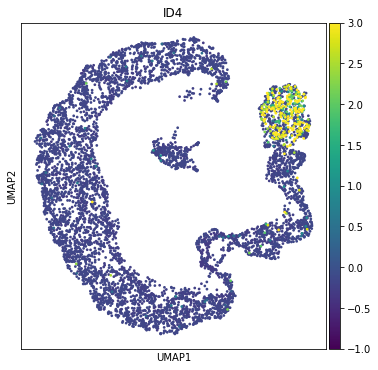

In [4]:
sc.plotting.umap(sample, color=markers['SpermatogoniaA'], vmin=-1, vmax=3, s=30)

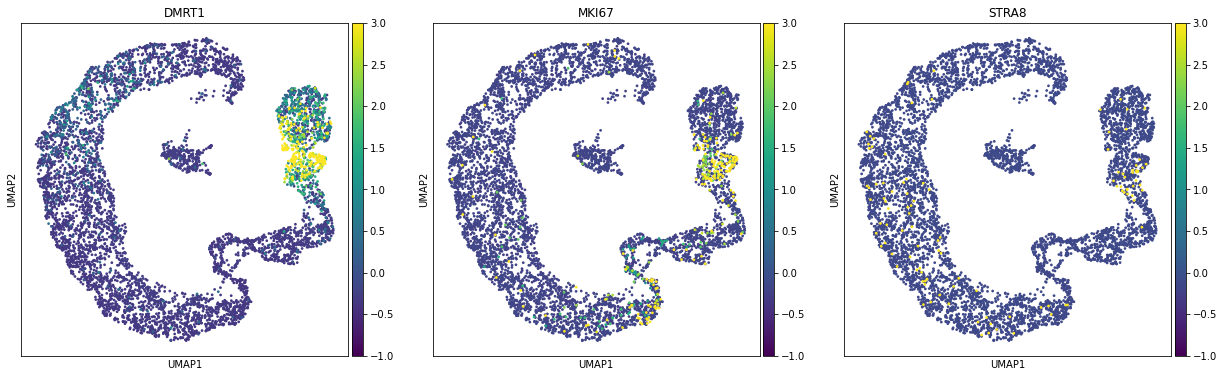

In [5]:
sc.plotting.umap(sample, color=markers['SpermatogoniaB'], vmin=-1, vmax=3, s=30)

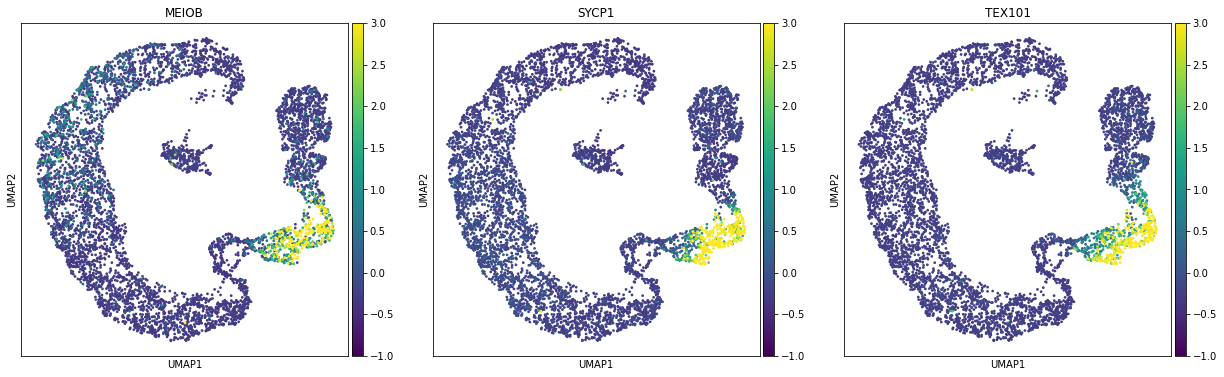

In [6]:
sc.plotting.umap(sample, color=markers['SpermatocytesI'], vmin=-1, vmax=3, s=30)

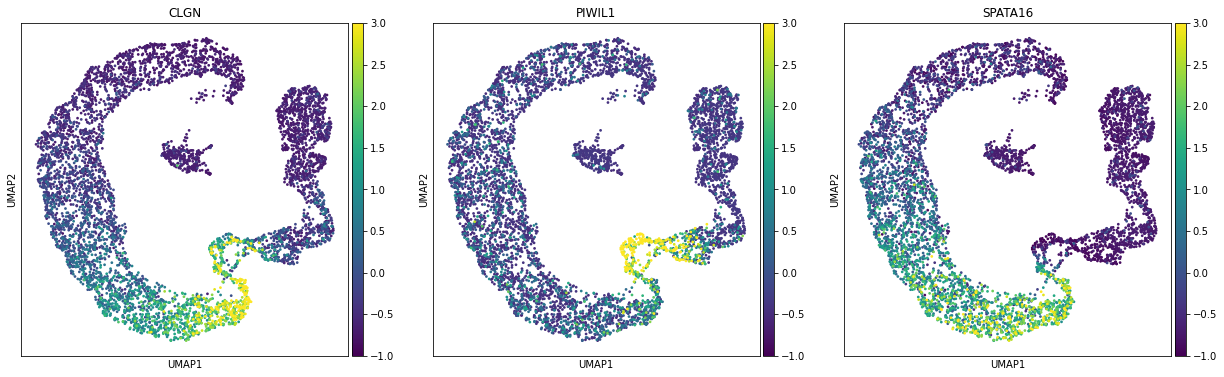

In [7]:
sc.plotting.umap(sample, color=markers['SpermatocytesII'], vmin=-1, vmax=3, s=30)

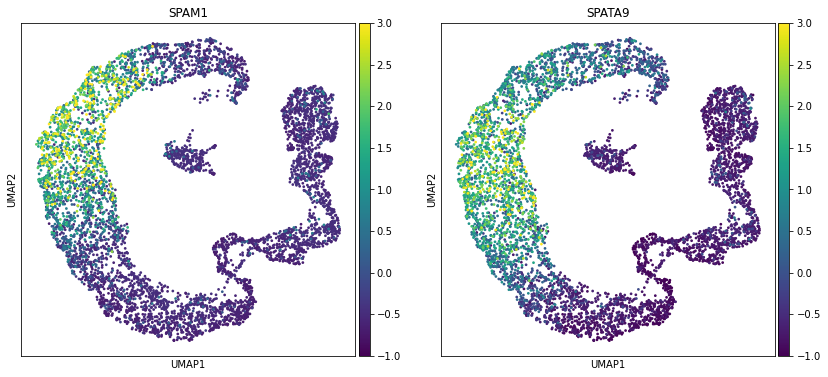

In [8]:
sc.plotting.umap(sample, color=markers['Round.Spt'], vmin=-1, vmax=3, s=30)

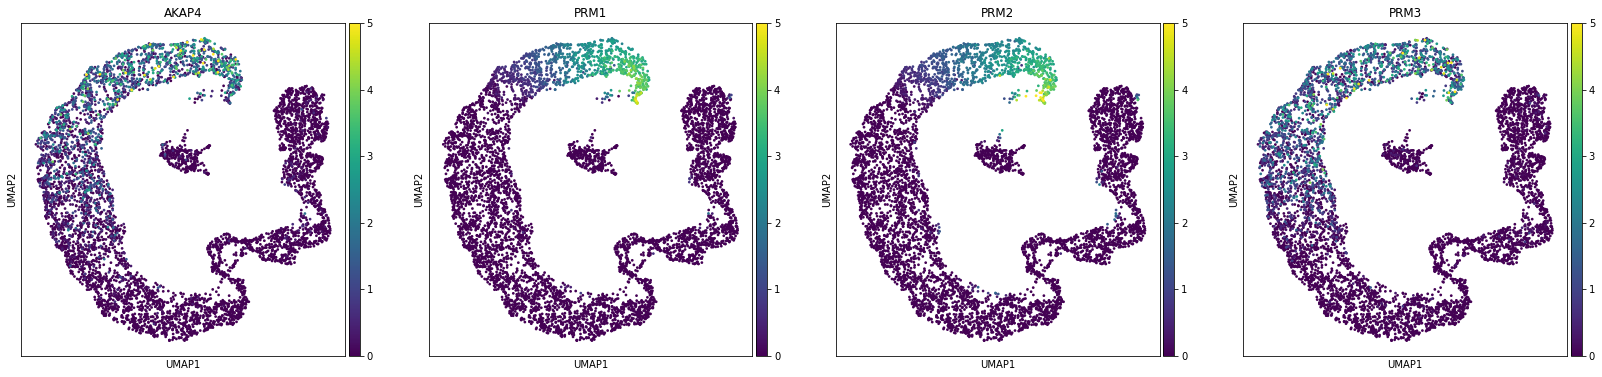

In [9]:
sc.plotting.umap(sample, color=markers['Elong.Spt'], vmin=0, vmax=5, s=30)

Sertoli are often not possible to identify. They are big in size, meaning they are often not isolated successfully. Many of their markers are in common with other somatic cells. Also, their function as nurse cells for germ cells of the testis means that their marker genes are also expressed. We can see that CTSL is expressed in some germ cells, but not in other clusters, while VIM is expressed in a likely somatic cluster (but it is common to other somatic cell types)

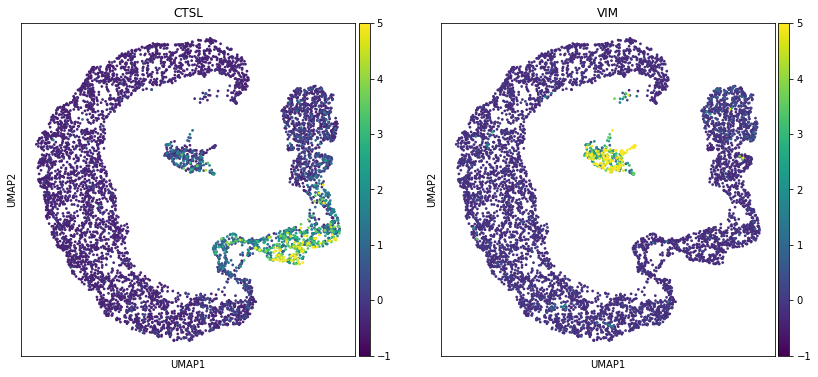

In [10]:
sc.plotting.umap(sample, color=markers['Sertoli'], vmin=-1, vmax=5, s=30)

Macrophage cells seem to be absent

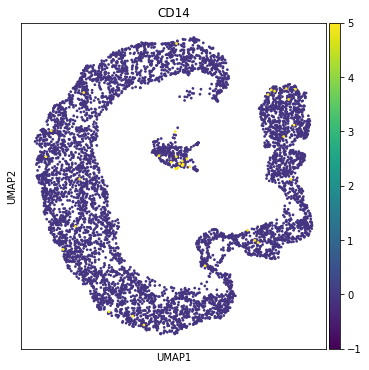

In [11]:
sc.plotting.umap(sample, color=markers['Macroph'], vmin=-1, vmax=5, s=30)

There is a little endothelial cluster

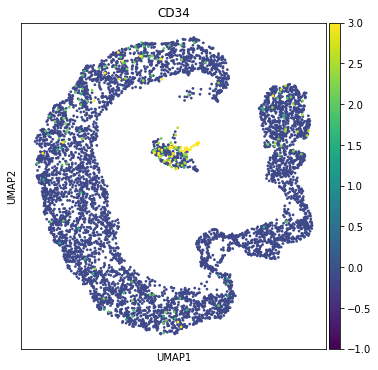

In [12]:
sc.plotting.umap(sample, color=markers['Endothelial'], vmin=-1, vmax=3, s=30)

and also a myoid cluster

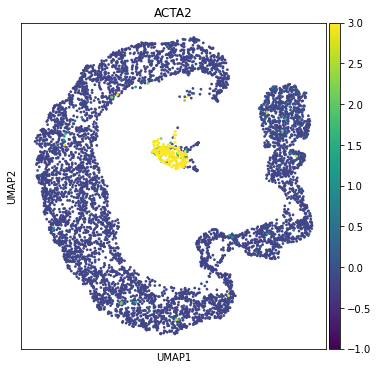

In [13]:
sc.plotting.umap(sample, color=markers['Myoid'], vmin=-1, vmax=3, s=30)

Leydig cells are likely to be missing as well

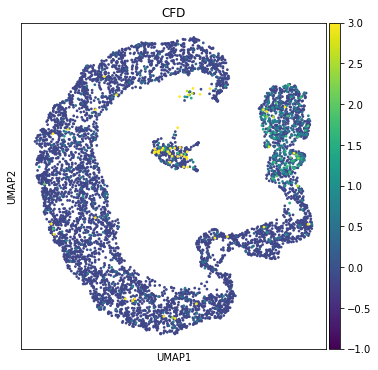

In [14]:
sc.plotting.umap(sample, color=markers['Leydig'], vmin=-1, vmax=3, s=30)

Now we create some clusters, and try to get the same division we saw by plotting markers. We can tune the number of clusters by changing the `resolution` parameter. We will be able to give the same name to more clusters, so it is fine to create a fine-grained clustering.

In [15]:
sc.tl.leiden(sample, resolution=.3, random_state=12345)

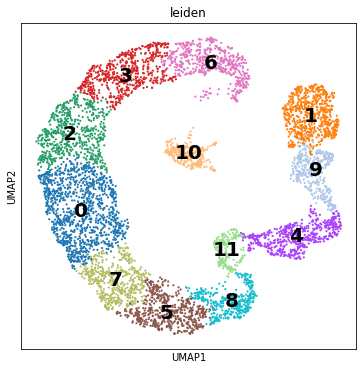

In [16]:
sc.plotting.umap(sample, color=['leiden'], legend_loc='on data', legend_fontsize=20)

We rename the clusters in the dictionary `new_names`. Clusters with the same name can be numbered with a dot, by writing for example `.1` and `.2` at the end of the names. We will remove the numbers afterwords.

In [17]:
clusters = pd.Categorical(sample.obs['leiden'])

In [18]:
new_names = {
    '0':'RoundSpermatids.2',
    '1':'SpermatogoniaA',
    '2':'RoundSpermatids.3',
    '3':'ElongSpermatids.2',
    '4':'SpermatocitesI',
    '5':'SpermatocitesII.3',
    '6':'ElongSpermatids.1',
    '7':'RoundSpermatids.1',
    '8':'SpermatocitesII.2',
    '9':'SpermatogoniaB',
    '10':'Somatic',
    '11':'SpermatocitesII.1'
}

we apply the new names

In [19]:
clusters=clusters.rename_categories(new_names)

we remove the numbers from same cell types

In [20]:
cluster_array = np.array(clusters)
split_array = [ i.split('.')[0] for i in cluster_array ]
clusters = pd.Categorical(split_array)

save the clusters in the sample and plot the new ones

In [21]:
sample.obs['clusters']=clusters.copy()

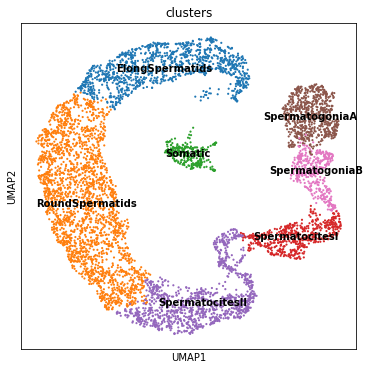

In [22]:
sc.plotting.umap(sample, color=['clusters'], legend_loc='on data')

We can look at markers in a heatmap or a dotplot

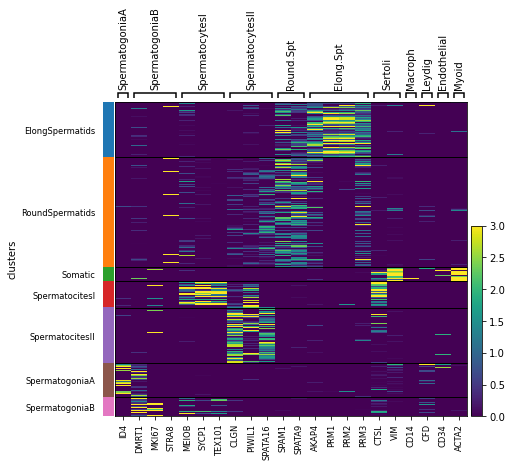

In [24]:
sc.pl.heatmap(sample, 
              groupby='clusters', 
              var_names=markers,
              vmin=0, vmax=3)

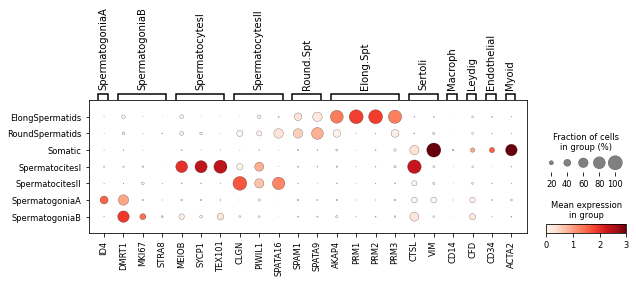

In [25]:
sc.pl.dotplot(sample, 
              groupby='clusters', 
              var_names=markers,
              vmin=0, vmax=3)

In [26]:
sample.write('../Data/notebooks_data/sample_123.filt.norm.red.clst.h5ad')

## Differential Expression (DE) analysis

We can do differential expression (DE) analysis to double check which genes are differentially expressed in each cluster. A gene is differentially expressed in a cluster when its expression in the cells of that cluster is statistically bigger than in all other cells. This is verified through a statistical test. 

Together with the gene names we also get p-values from the test, and a factor (`log-fold change`) telling the magnitude of how much the expression is larger than in other cells.

In [27]:
sample.X = sample.layers['umi_sct'].copy()
sc.pp.log1p(sample)

Apply the differential expression tool on the clusters for the top ten genes of each cluster. Save the results in `.uns[DE_clusters]`

In [28]:
sc.tl.rank_genes_groups(sample, groupby='clusters', key_added='DE_clusters', 
                        use_raw=False, n_genes=10, method='wilcoxon')

Access the list of names

In [29]:
pd.DataFrame(sample.uns['DE_clusters']['names'])

ElongSpermatids RoundSpermatids Somatic SpermatocitesI SpermatocitesII  \
0            PRM1          SPACA1   RPL10        C5orf58      AL133499.1   
1            TNP1            EQTN  TMSB4X        HORMAD1          PPP3R2   
2       LINC01921          CLDND2  EEF1A1           TPTE           COPRS   
3            PRM2          FAM24A     VIM        C5orf47         ZMYND10   
4           TEX37          CCDC82     B2M          TDRG1          MRPL34   
5            GLUL          FNDC11   RPL41           LY6K            LYAR   
6      AC010255.3           HMGN1    MYL6          CALM2            LDHC   
7            OAZ3           ARMH2    RPS8          GIHCG          SPINK2   
8           LELP1          TMEM89    CD63        ARL6IP1          CAVIN3   
9           TEX44        C17orf50  MALAT1          SYCP3            CLGN   

  SpermatogoniaA SpermatogoniaB  
0           CCNI          HMGB1  
1          RPS12           PTMA  
2         DNAJB6           SMC3  
3          RPS19           NASP  
4           RPSA            VCX  
5          FKBP8          CIRBP  
6         RPL18A          TKTL1  
7         EEF1B2          YWHAE  
8         ZNF428          CENPH  
9        HNRNPDL         SDF2L1

Access the table including p-values (with suffix `_P` in each column) and log-fold change (with suffix `_L` in each column)

In [30]:
result = sample.uns['DE_clusters']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
X

ElongSpermatids_N  ElongSpermatids_P  ElongSpermatids_L RoundSpermatids_N  \
0              PRM1                0.0           5.144500            SPACA1   
1              TNP1                0.0           5.429896              EQTN   
2         LINC01921                0.0           4.902085            CLDND2   
3              PRM2                0.0           5.015192            FAM24A   
4             TEX37                0.0           5.186311            CCDC82   
5              GLUL                0.0           3.833078            FNDC11   
6        AC010255.3                0.0           4.170074             HMGN1   
7              OAZ3                0.0           3.759861             ARMH2   
8             LELP1                0.0           3.584986            TMEM89   
9             TEX44                0.0           4.480875          C17orf50   

   RoundSpermatids_P  RoundSpermatids_L Somatic_N      Somatic_P  Somatic_L  \
0                0.0           3.777169     RPL10  2.525592e-174   6.076777   
1                0.0           4.248300    TMSB4X  2.525592e-174   7.169009   
2                0.0           3.898438    EEF1A1  6.766057e-174   3.174674   
3                0.0           5.742062       VIM  1.792903e-173   5.921922   
4                0.0           2.918629       B2M  8.618616e-173   6.509422   
5                0.0           3.061646     RPL41  8.618616e-173   3.041772   
6                0.0           2.964078      MYL6  1.205244e-172   4.175120   
7                0.0           3.936198      RPS8  1.205244e-172   3.006661   
8                0.0           3.487217      CD63  2.523182e-172   5.367240   
9                0.0           3.186110    MALAT1  1.805388e-171   4.442494   

  SpermatocitesI_N  ...  SpermatocitesI_L  SpermatocitesII_N  \
0          C5orf58  ...          4.501788         AL133499.1   
1          HORMAD1  ...          3.796773             PPP3R2   
2             TPTE  ...          5.254562              COPRS   
3          C5orf47  ...          3.404744            ZMYND10   
4            TDRG1  ...          5.681285             MRPL34   
5             LY6K  ...          5.748628               LYAR   
6            CALM2  ...          3.509185               LDHC   
7            GIHCG  ...          4.256285             SPINK2   
8          ARL6IP1  ...          3.666462             CAVIN3   
9            SYCP3  ...          4.165550               CLGN   

  SpermatocitesII_P  SpermatocitesII_L  SpermatogoniaA_N SpermatogoniaA_P  \
0               0.0           3.853604              CCNI              0.0   
1               0.0           2.889049             RPS12              0.0   
2               0.0           2.991765            DNAJB6              0.0   
3               0.0           3.013097             RPS19              0.0   
4               0.0           3.702655              RPSA              0.0   
5               0.0           3.280008             FKBP8              0.0   
6               0.0           2.769597            RPL18A              0.0   
7               0.0           2.466922            EEF1B2              0.0   
8               0.0           3.572695            ZNF428              0.0   
9               0.0           3.234808           HNRNPDL              0.0   

   SpermatogoniaA_L  SpermatogoniaB_N SpermatogoniaB_P  SpermatogoniaB_L  
0          5.031026             HMGB1    2.390085e-224          4.138800  
1          3.337157              PTMA    4.815253e-224          4.646809  
2          4.128599              SMC3    7.098368e-207          4.447907  
3          3.584053              NASP    1.323427e-205          3.823005  
4          4.171309               VCX    1.323427e-205          4.343319  
5          2.252112             CIRBP    2.812984e-205          4.059045  
6          4.907641             TKTL1    4.065276e-204          4.602732  
7          2.884277             YWHAE    1.195658e-191          2.110071  
8          3.828348             CE

We can easily save the table in csv format. This can be opened in Excel.

In [31]:
X.to_csv('../Data/results/diff_expression_clusters.csv', header=True, index=False)

## Subclustering the data

We find subclusters of cells using markers for cell types that are found between late spermatogonia and spermatocites.

In [32]:
#Clusters to be subsetted
SUBGROUPS = ['SpermatogoniaB','SpermatocitesI','SpermatocitesII'] 

In [33]:
#Markers for the processes involved in late spermatogonia and spermatocites
markers['Leptotene'] = ['SYCE2','SCML1']
markers['Zygotene'] = ['LY6K', 'SYCP1']
markers['Pachytene'] = ['PIWIL1','CCDC112']
markers['Diplotene'] = ['OVOL2','CCNA1', 'CDK1','AURKA']

Let's look at the markers plottes only over the cells of the clusters `SpermatogoniaB`, `SpermatocitesI` and `SpermatocitesII`

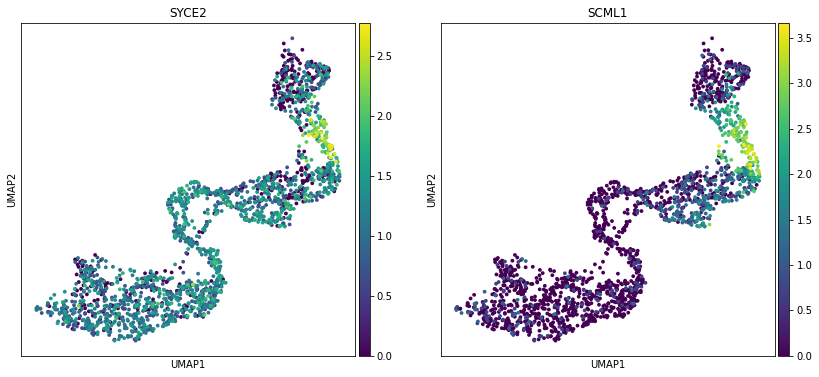

In [34]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Leptotene'])

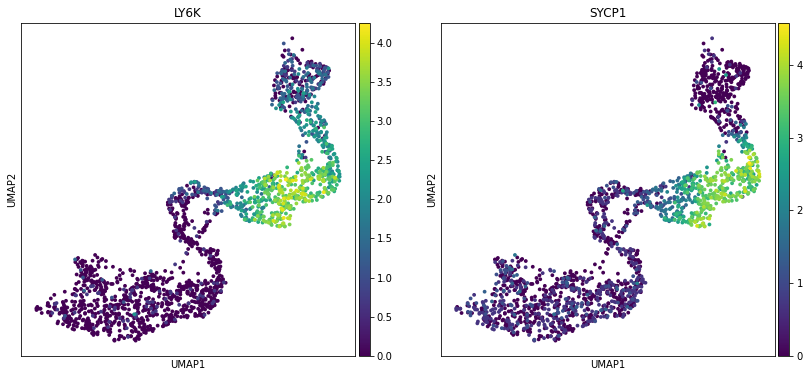

In [35]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Zygotene'])

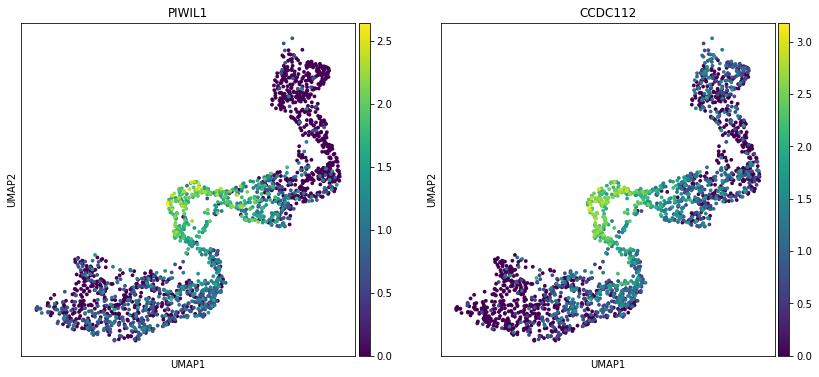

In [36]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Pachytene'])

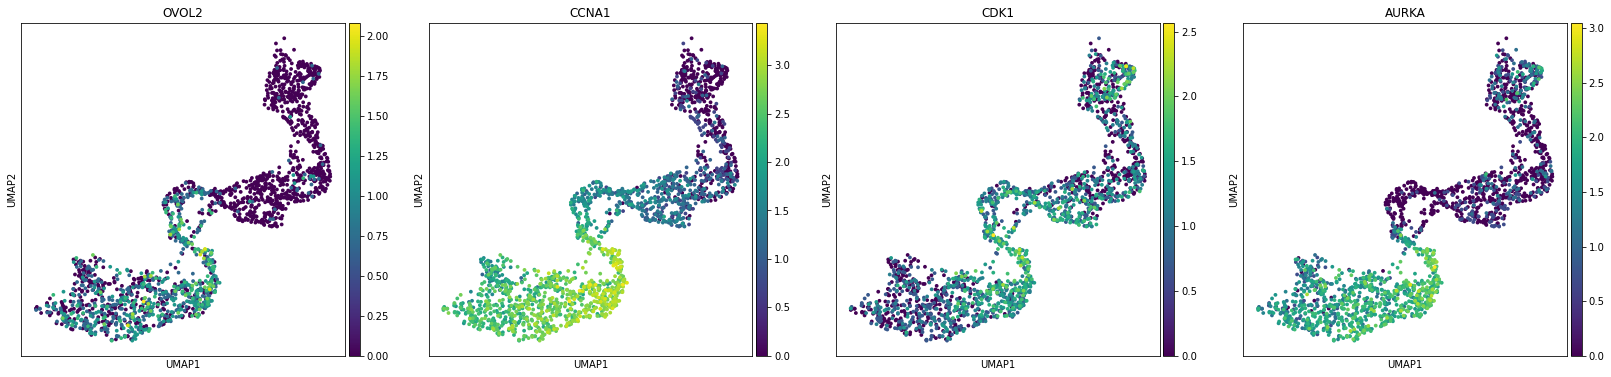

In [37]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Diplotene'])

We want to create new clusters in our dataset by starting from the old clustering. To do this we use the option `restrict_to`, where we write the name of the old clustering, and the name of which clusters we want to subset

In [38]:
sc.tl.leiden(sample, resolution=.35, key_added='clusters_spc',
            restrict_to=('clusters', SUBGROUPS),
            random_state=12345)

Let's look at the new clustering of `spermatogoniaB` and `spermatocites I/II`

Trying to set attribute `.uns` of view, copying.


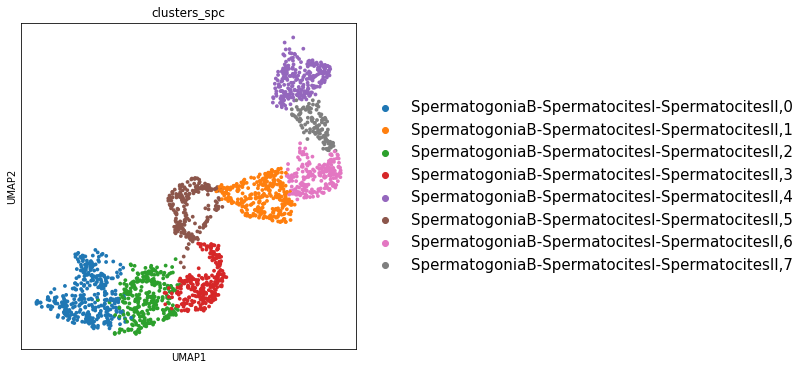

In [39]:
sc.pl.umap(sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=['clusters_spc'], legend_fontsize=15)

Names are very long. We keep only the numbers at the end

In [40]:
clusters = sample.obs['clusters_spc']
cluster_array = np.array(clusters)
split_array = [ i.split(',')[1] if ',' in i else i for i in cluster_array]
clusters = pd.Categorical(split_array)
sample.obs['clusters_spc']=clusters.copy()

Trying to set attribute `.uns` of view, copying.


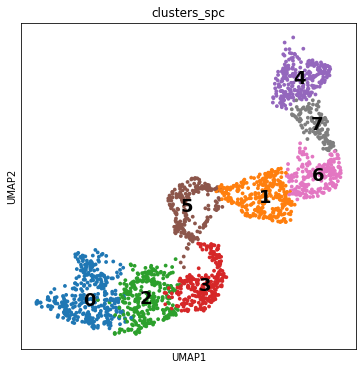

In [41]:
sc.pl.umap(sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=['clusters_spc'], legend_loc='on data', legend_fontsize=18)

Before renaming, we also want to look at the differentially expressed genes. We should be able to find at least some of the markers used in the plots. However, it can be that those do not appear because there are many other coexpressed genes with high expression values.

In [42]:
sample.X = sample.layers['umi_sct'].copy()
sc.pp.log1p(sample)

In [43]:
sc.tl.rank_genes_groups(sample, groupby='clusters_spc', key_added='DE_clusters_spc',
                        use_raw=False, n_genes=20, method='wilcoxon')

We can find some of the marker genes. For example `SCML1` for leptotene cells (cluster 7), `SYCP1` and `LY6K` for zygotene (only in cluster 6 and not in cluster 1), `CCDC112` and `PIWIL1` for pachitene (cluster 5), `CCNA1` and `AURKA` for zygotene (clusters 3,2,0). 

In [44]:
pd.DataFrame(sample.uns['DE_clusters_spc']['names'])

0           1           2           3         4          5  \
0        TBPL1        TPTE  AL133499.1       CCNA1      PTMA   C15orf48   
1        SNRPC     C5orf58        GYG1     CIAPIN1     HMGB1  STIM2-AS1   
2   AL133499.1      TMEM99     ZMYND10      ASRGL1      CFL1    CCDC112   
3        ISOC2       GIHCG       CCNA1        CLGN     CIRBP      CETN3   
4       CCDC42      SPATA8        LDHC      PPP3R2      APRT     COX7A2   
5        H2AFJ       H2AFZ       COPRS     NDUFAF3   TRMT112       PHF7   
6       ETFRF1        CKLF       ISOC2        LDHC      RPS2      RNFT1   
7       CAVIN3       CALM2       SNRPC  AL133499.1     PRAME     MGAT4D   
8         GYG1       H3F3B      CAVIN3        RAE1     TKTL1      GMCL2   
9       FBXO25     ARL6IP1      PPP3R2      MRPL34     CCT6A     RPL39L   
10         UBB       TDRG1      MRPL34       AURKA     RNPS1     CAPNS1   
11       CCNB2  AC044839.1        RAE1       ISOC2  PAFAH1B3     PIWIL1   
12      CDRT15    SLC25A31        LYAR      CAVIN3      NASP      GIHCG   
13         PBK      PRSS21       TBPL1        GYG1     YWHAE      TERB2   
14        LDHC       KDM5B      ASRGL1       COPRS     CKS1B    FAM174A   
15        CT66     HORMAD1       AURKA        LYAR      LSM2    MORF4L1   
16      TMIGD3       STMN1        CLGN     ZMYND10     HMGN2     CFAP53   
17   MCHR2-AS1       CRNDE     ZC2HC1C    TMPRSS12     PARP1     SPINK2   
18     ZC2HC1C  AL354707.1       APH1B      SPINK2      RBM3     ADAM18   
19    CATSPERZ        TBCA      UQCR10  AC005041.4       DEK       PENK   

          6        7 ElongSpermatids RoundSpermatids  Somatic SpermatogoniaA  
0    TEX101      VCX            PRM1          SPACA1    RPL10           CCNI  
1     SYCP1    CLSPN            TNP1            EQTN   TMSB4X          RPS12  
2   SELENOT    VCX3B       LINC01921          CLDND2   EEF1A1         DNAJB6  
3      LY6K    TEX19            PRM2          FAM24A      VIM          RPS19  
4    ZCWPW1    SCML1           TEX37          CCDC82      B2M           RPSA  
5   C5orf47     SMC3            GLUL          FNDC11    RPL41          FKBP8  
6     SYCP3    GINS2      AC010255.3           HMGN1     MYL6         RPL18A  
7   HSP90B1     CBX1            OAZ3           ARMH2     RPS8         EEF1B2  
8    FMR1NB    HMGB1           LELP1          TMEM89     CD63         ZNF428  
9      NPC2    SMC1B           TEX44        C17orf50   MALAT1        HNRNPDL  
10     RHEB    PAGE1        C10orf62         C7orf61   RPL13A         TUBA1B  
11  C5orf58    DPEP3           HMGB4          SSMEM1    CALD1          YWHAB  
12  TMEM147    TAF12            ESS2      AC022784.5  SPARCL1           RPS5  
13  HORMAD1     VCX2       C20orf141         C4orf17      MGP          EGFL7  
14     SMC3    VPS29          CEP170           AFG1L   RPL10A          RPS21  
15    EIF1B    SYCP3         P3R3URF            TJP3      FTL         LYPLA1  
16   DYNLL1   PRSS21           SPEM1           LYZL6   TMSB10          RPLP0  
17    KIF5B    HMGB2           OTUB2           LYZL1    RPS4X       PAFAH1B3  
18    SMC1B    VCX3A           FNDC8           LYZL2   RPL27A          RPS28  
19    STMN1  ZCCHC17           TSSK6           TFDP2     MYL9           FTH1

We can again look at p-values and log-fold changes

In [45]:
result = sample.uns['DE_clusters_spc']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

and save the table

In [46]:
X.to_csv('../Data/results/diff_expression_subclusters.csv', header=True, index=False)

We can look at only the columns of a cluster from the large table so it is more readable

In [47]:
X[ ['7_N','7_L','7_P'] ] #Leptotene cluster 7

7_N       7_L           7_P
0       VCX  5.085259  1.880046e-74
1     CLSPN  5.670344  8.958750e-73
2     VCX3B  4.970201  6.472854e-72
3     TEX19  8.401729  2.968744e-71
4     SCML1  5.464262  2.968744e-71
5      SMC3  4.857344  4.241376e-71
6     GINS2  4.931968  7.885178e-71
7      CBX1  4.003250  3.821947e-70
8     HMGB1  4.195180  4.890995e-70
9     SMC1B  4.522772  1.369898e-69
10    PAGE1  5.054068  1.485504e-69
11    DPEP3  4.943869  2.975243e-69
12    TAF12  3.664352  2.975243e-69
13     VCX2  4.427177  7.244536e-69
14    VPS29  3.429123  8.254675e-69
15    SYCP3  4.445552  3.004139e-68
16   PRSS21  3.556168  2.217609e-67
17    HMGB2  4.008800  3.577135e-67
18    VCX3A  4.829657  7.448731e-67
19  ZCCHC17  3.466318  8.420134e-67

We rename the new clusters

In [48]:
clusters = pd.Categorical(sample.obs['clusters_spc'])

In [49]:
new_names = {
    '0':'Diplotene.1',
    '1':'Zygotene.2',
    '2':'Diplotene.2',
    '3':'Diplotene.3',
    '4':'SpermatogoniaB',
    '5':'Pachytene',
    '6':'Zygotene.1',
    '7':'Leptotene'
}

In [50]:
clusters=clusters.rename_categories(new_names)

In [51]:
cluster_array = np.array(clusters)
split_array = [ i.split('.')[0] for i in cluster_array ]
clusters = pd.Categorical(split_array)

In [52]:
sample.obs['clusters_spc']=clusters.copy()

Just a plot of the two clustering side by side

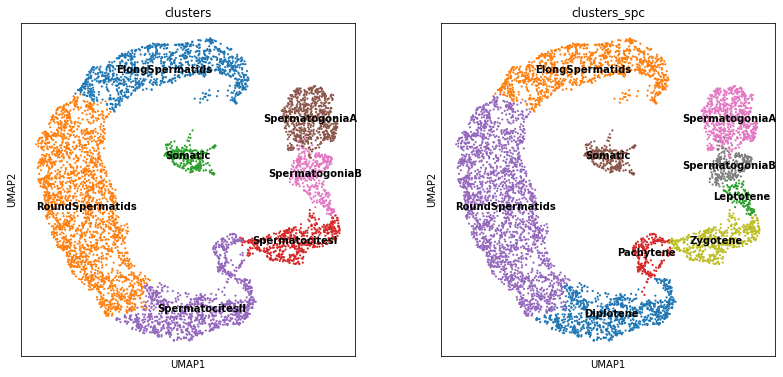

In [53]:
sc.plotting.umap(sample, color=['clusters','clusters_spc'], legend_loc='on data')

We can quickly repeat the same procedure for the somatic cells.

In [54]:
SUBGROUPS = ['Somatic']

In [55]:
sc.tl.leiden(sample, resolution=.1, key_added='clusters_som',
            restrict_to=('clusters_spc', SUBGROUPS),
            random_state=12345)

Trying to set attribute `.uns` of view, copying.


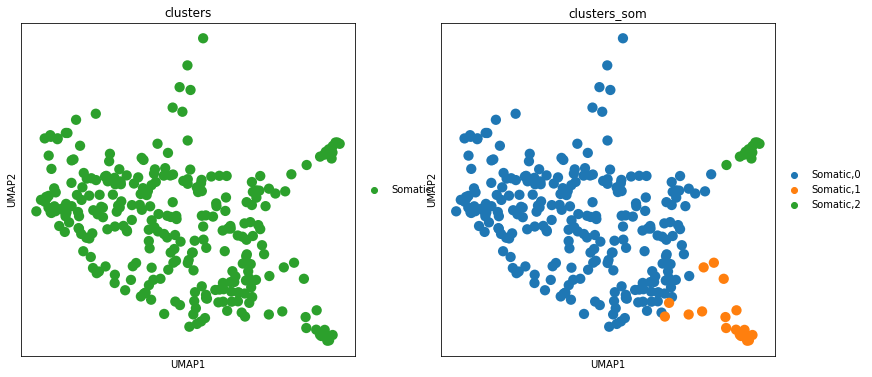

In [56]:
sc.pl.umap(sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=['clusters','clusters_som'])

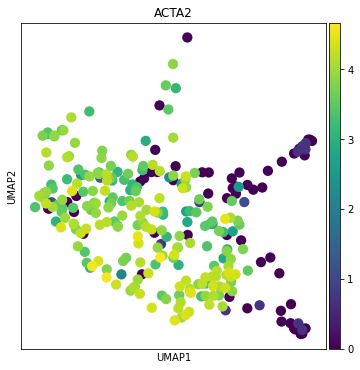

In [57]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Myoid'])

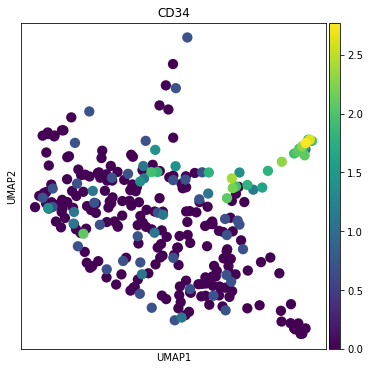

In [58]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Endothelial'])

We rename the clusters. One of them seems impossible to identify, so we will just remove it from the data (it is only around ten cells)

In [59]:
clusters = pd.Categorical(sample.obs['clusters_som'])

In [60]:
new_names = {
    'Somatic,0': 'Myoid',
    'Somatic,2': 'Endothelial'
}

In [61]:
clusters=clusters.rename_categories(new_names)

In [62]:
cluster_array = np.array(clusters)
split_array = [ i.split('.')[0] for i in cluster_array ]
clusters = pd.Categorical(split_array)

In [63]:
sample.obs['clusters_som']=clusters.copy()

We remove the unidentified cluster

In [64]:
sample = sample[ sample.obs['clusters_som']!='Somatic,1' ].copy()

Now we can see how the clustering has been developing

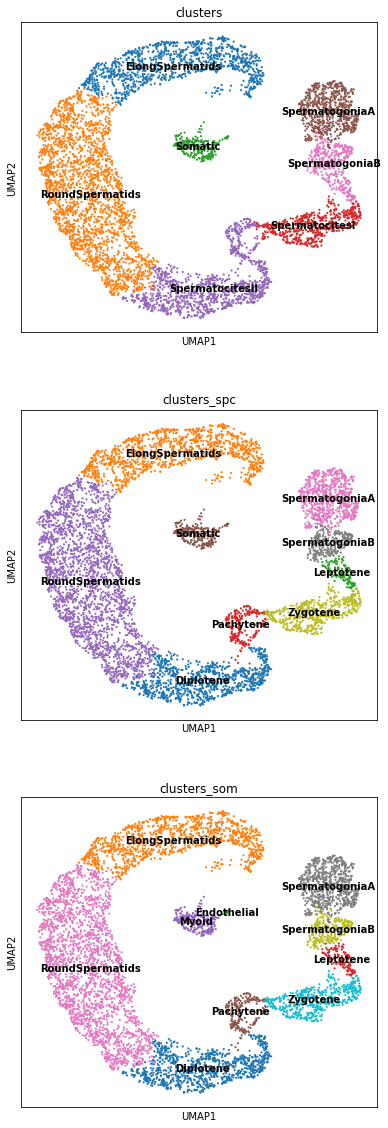

In [65]:
sc.plotting.umap(sample, color=['clusters','clusters_spc','clusters_som'], 
                 legend_loc='on data', ncols=1)

You can plot the correlation matrix of the clusters.

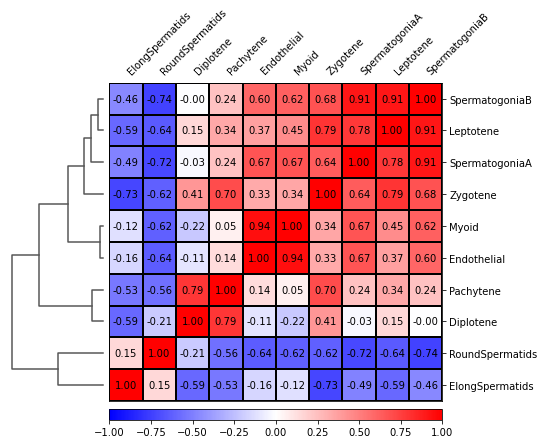

In [69]:
sc.pl.correlation_matrix(sample, groupby='clusters_som', 
                         show_correlation_numbers=True)

Look at the proportion of each cell type in the data

In [73]:
#number of cells
sample.obs['clusters_som'].value_counts()

RoundSpermatids    2245
ElongSpermatids    1138
Diplotene           947
SpermatogoniaA      681
Zygotene            523
SpermatogoniaB      275
Myoid               254
Pachytene           215
Leptotene           123
Endothelial          12
Name: clusters_som, dtype: int64

In [74]:
#Percentage of cells
sample.obs['clusters_som'].value_counts() / sample.shape[0] * 100

RoundSpermatids    35.007017
ElongSpermatids    17.745205
Diplotene          14.766880
SpermatogoniaA     10.619055
Zygotene            8.155310
SpermatogoniaB      4.288165
Myoid               3.960705
Pachytene           3.352565
Leptotene           1.917979
Endothelial         0.187120
Name: clusters_som, dtype: float64

finally, save the data

In [70]:
sample.write('../Data/notebooks_data/sample_123.filt.norm.red.clst.2.h5ad')

## Wrapping up

We have been showing how to simply identify potential cell clusters. At least in this dataset, the cells change from one type to another in a continuous process, so such a hard clustering does not completely reflect biological reality. However, it is a good approximation, as it is illustrated by the differentially expressed genes we could check in each cluster.
We introduced how to perform differential expression, and what are the useful values that we get from it (p-value of the test, magnitude of the gene expression compared to all other clusters). Finally, we subsetted the data into a more fine grained cell identification.